To install Unity mlagent library follow the instruction provided in their documentaion

https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md

In [1]:
# To test if the library instalation successfull run the following
from mlagents.envs import UnityEnvironment
# If no error occors instalation is success 

Download the game from following link
https://drive.google.com/drive/u/0/folders/155Z71QdXSCa7XRmnzXggb1ZwJl-A6iZd

<b> Windows users : </b> windows_build 

<b> Linux users   : </b> linux_build

In [2]:
# Game access class 
# Can be found in : https://github.com/CORGI-lab/DQNFrogger/blob/master/GameHandler.py

In [3]:
import skimage
from mlagents.envs import UnityEnvironment
import numpy as np


# -- game handling class -- #
class Game:

    """
    set up unity ml agent environment
    @:param game_location  : file path for executable
    """
    def __init__(self, game_location):
        self.ENV_LOCATION = game_location
        self.load_env(0)

    """
    load unity environment
    @:param wid  : id for the worker in unity environment 
    """
    def load_env(self, wid):
        # load env
        env_name = self.ENV_LOCATION
        self.env = UnityEnvironment(env_name, worker_id=wid)
        # Set the default brain to work with
        self.default_brain = self.env.brain_names[0]
        self.brain = self.env.brains[self.default_brain]
        # Reset the environment - train mode enabled
        env_info = self.env.reset(train_mode=True)[self.default_brain]

    # this frogger game action space is 5, actions[0] = selected action (action = [[1]])
    # actions
    # 1 - up, 2 - down , 3- left , 4 -right , 0 - do nothing
    """
    performs a given action to the unity game 
    @:param action_value : action to be execute
    @:param image_height : Desire image height 
    @:param image_width  : Desire image width 
    @:param number_of_frames : stack size (this number of frames will e stack together by performing no op action )
    @:return reward : reward for the action 
    @:return stack  : stack of frames
    @:return terminal : if game reached terminal state or not
    """
    def perform_action(self, action_value, image_height, image_width, number_of_frames=4):
        action = [[0]]
        action[0] = action_value
        terminal = False  # indication of terminal state
        # 3 - R, G, B
        size = (image_height, image_width, 3, number_of_frames)  # create list to keep frames
        stack = np.zeros(size)

        # first frame after action
        env_info = self.env.step(action)[self.default_brain]  # send action to brain
        reward = round(env_info.rewards[0], 5)  # get reward
        new_state = env_info.visual_observations[0][0]  # get state visual observation
        # new_state_gray = skimage.color.rgb2gray(new_state)  # covert to gray scale
        new_state_gray = skimage.transform.resize(new_state, (image_height, image_width))  # resize
        # check terminal reached
        if env_info.local_done[0]:
            terminal = True

        # add the state to the 0 th position of stack
        stack[:, :, :, 0] = new_state_gray

        # get stack of frames after the action
        for i in range(1, number_of_frames):
            env_info = self.env.step()[self.default_brain]  # change environment to next step without action
            st = env_info.visual_observations[0][0]
            #st_gray = skimage.color.rgb2gray(st)
            st_gray = skimage.transform.resize(st, (image_height, image_width))
            stack[:, :, :, i] = st_gray
            # if terminal only consider the reward for terminal
            if env_info.local_done[0]:
                terminal = True
                reward = round(env_info.rewards[0], 5)

        # reshape for Keras
        # noinspection PyArgumentList
        stack = stack.reshape(1, stack.shape[0], stack.shape[1], stack.shape[2], stack.shape[3])

        return reward, stack, terminal

    """
    close environment
    """
    def close(self):
        self.env.close()

    """
    Reset environment 
    """
    def reset(self):
        self.close()
        self.load_env(0)

In [4]:
# Create new unity game environment

# provide game location / game executable file name shoud be givn without the file extention 
game_loation  = "windows_build/UnityFrogger"
new_game = Game(game_loation)

INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: frogLearn
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [5]
        Vector Action descriptions: 
Unity brain name: frogplay
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [1]
        Vector Action descriptions: 


In [5]:
# send action to game 
# Valid actions for this game : 
#     0 - no operation 
#     1 - move up
#     2 - move down
#     3 - move left
#     4 - move right

action =  0 # action to be send to the game 

# image size that you need to get as out put 
image_height  = 320 
image_width   = 320 

# send action to game 
# Output provide by this method are: 
#   reward   :  reward value for the action
#   stack    :  stack of 4 frames with the array of size  (1, image_height, image_width, 4)
#   terminal :  if the new state reached a terminal or not (true : terminal, false : non-terminal)
reward,stack,terminal = new_game.perform_action(action, image_height, image_width)

In [6]:
print("Action              :", action)
print("Reward              :", reward)
print("Is terminal reached :", terminal)

Action              : 0
Reward              : 0.0
Is terminal reached : False


In [7]:
# Access frames 
import matplotlib.pyplot as plt

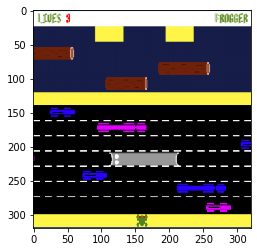

In [8]:
# This will provide the 1 st frame in the frame stack
plt.imshow(stack[0][:,:,:,0]) # to access other frames change last 0 in the stack list to desire frame number 

In [9]:
# close unity game
new_game.close()